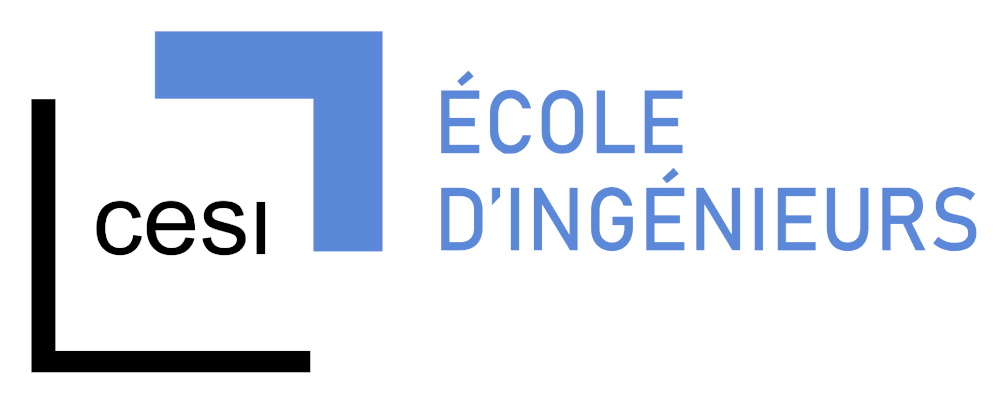<p style='text-align: center'>
    <div style='text-align: center'>Cesi A5</div>
</p>



# Leyenda - Image classification

## **Table Of Contents**
> 1. [Objective](#1)
> 2. [Data](#2)
> 3. [Notebook imports](#3)
> 4. [Importing data](#4)
> 5. [Hyper-parameters](#5)
> 6. [Deep Neural Networks](#6)
> 7. [Convolutional Neural Networks](#7)
> 8. [Improving models](#8)
> 9. [Improving training](#9)
> 10. [Transfer Learning](#10)
> 11. [Results](#11)

## Objective <a class="anchor" id="1"></a> 

This notebook presents our implementation of an image classifier using Deep Learning.

It gathers our design process steps and idea on how to create the most accurate and efficient Neural Network for this task.

Please note that you ned to run this notebook code on your own, **you may encounter different accuracy results** than the ones we obtained. <br>
This is due to the way the `model.evaluate()` function works in TensorFlow.

## Data <a class="anchor" id="2"></a> 

The dataset is composed of 41.406 images splits into 5 different classes: painting (10.000), photo (10.000), schematic (10.000), sketch (1406) and text (10.000). <br>
The images are either in .jpeg or .png format and come in variety of dimensions.

To make this notebook more easy to read, the original dataset has been pre-splits into a training (80%), validation (10%) and testing (10%) set, and then uploaded into a [Kaggle dataset](https://www.kaggle.com/datasets/eccsx20/image-type-classification). <br>
We also remove all non-processable images, due to invalid format or wrong color profile.

## Notebook imports <a class="anchor" id="3"></a> 

In [1]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.image import psnr, ssim
from tensorflow.keras.callbacks import History

import numpy as np

def is_model_already_trained(model):
    weights_path = '/kaggle/working/models/weights/' + model.name + '.h5'
    history_path = '/kaggle/working/models/history/' + model.name + '.json'
    
    is_weights = os.path.exists(weights_path)
    is_history = os.path.exists(history_path)
    
    if is_weights and is_history:
        return True
    else:
        if is_weights:
            os.remove(weights_path)
        if is_history:
            os.remove(history_path)
        return False


def save_model_training(model):
        # Define directory paths
    weights_dir = '/kaggle/working/models/weights/'
    history_dir = '/kaggle/working/models/history/'

    # Create directories if they do not exist
    os.makedirs(weights_dir, exist_ok=True)
    os.makedirs(history_dir, exist_ok=True)

    # Update the paths
    weights_path = os.path.join(weights_dir, model.name + '.h5')
    history_path = os.path.join(history_dir, model.name + '.json')
    
    # Save the model weights
    model.save_weights(weights_path)
    
    # Save the training history to a JSON file
    with open(history_path, 'w') as f:
        json.dump(model.history.history, f)


def load_model_training(model):
    # Define the paths within the Kaggle working directory
    weights_path = '/kaggle/working/models/weights/' + model.name + '.h5'
    history_path = '/kaggle/working/models/history/' + model.name + '.json'
    
    # Load the model weights
    model.load_weights(weights_path)
    
    # Load the training history from the JSON file
    model.history = History()
    with open(history_path, 'r') as f:
        model.history.history = json.load(f)
    model.history.epoch = list(range(len(model.history.history['loss'])))
        

def plot_model_history(model):
    history = model.history.history
    epoch = model.history.epoch
    keys = list(history.keys())
    palette = iter(sns.color_palette())
    
    fig, axs = plt.subplots(1, 2,
                            figsize=(15, 5),
                            sharex=True)
    
    sns.lineplot(x=epoch, y=history[keys[0]],
                 color=next(palette),
                 ax=fig.axes[0],
                 label=keys[0])
    sns.lineplot(x=epoch, y=history[keys[2]],
                 color=next(palette),
                 ax=fig.axes[0],
                 label=keys[2])

    sns.lineplot(x=epoch, y=history[keys[1]],
                 color=next(palette),
                 ax=fig.axes[1],
                 label=keys[1])
    sns.lineplot(x=epoch, y=history[keys[3]],
                 color=next(palette),
                 ax=fig.axes[1],
                 label=keys[3])

    fig.suptitle(f'{model.name} training history')
    fig.supxlabel('epoch')
    
    axs[0].set_title('loss')
    axs[1].set_title('accuracy')
    
    plt.tight_layout()


def plot_models_history(models):
    palette = iter(sns.color_palette())
    
    fig, axs = plt.subplots(1, 4,
                            figsize=(15, 5),
                            sharex=True)
    
    for m in models:
        history = m.history.history
        keys = list(history.keys())
        epoch = m.history.epoch
        color = next(palette)
    
        sns.lineplot(x=epoch, y=history[keys[0]],
                     color=color,
                     ax=fig.axes[0],
                     label=m.name)
        
        sns.lineplot(x=epoch, y=history[keys[2]],
                     color=color,
                     ax=fig.axes[1],
                     label=m.name)

        sns.lineplot(x=epoch, y=history[keys[1]],
                     color=color,
                     ax=fig.axes[2],
                     label=m.name)
        
        sns.lineplot(x=epoch, y=history[keys[3]],
                     color=color,
                     ax=fig.axes[3],
                     label=m.name)
        
    axs[0].set_title(keys[0])
    axs[1].set_title(keys[2])
    axs[2].set_title(keys[1])
    axs[3].set_title(keys[3])

    fig.suptitle('training history comparision')
    fig.supxlabel('epoch')
    
    plt.tight_layout()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!pip install watermark
!pip install wget
!pip install visualkeras
%load_ext watermark

import warnings
warnings.filterwarnings("ignore")

# File manipulation
import os
import pathlib
import shutil
import wget
import zipfile

# Data manipulation
import numpy as np

# Machine Learning

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Input, Flatten, MaxPool2D
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as tf_hub

tf.random.set_seed(1234)

# Image manipulation
import imghdr
from PIL import ImageFile

# Options for PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import visualkeras

# Options for seaborn
sns.set_style('darkgrid')
%matplotlib inline


%watermark -p watermark,wget,numpy,sklearn,tensorflow,tensorflow_hub,PIL,matplotlib,seaborn,visualkeras

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=4d79537d8f943132b7fbe09f06d581ef4eb65d342a9b9cdc191ae087e90cfd39
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 14.4 MB/s eta 0:00:00a 0:00:01
watermark     : 2.4.3
wget          : 3.2
numpy         : 1.23.5
sklearn       : 1.2.2
tensorflow    : 2.12.0
tensorflow_hub: 0.12.0
PIL           : 9.5.0
matplotlib    : 3.7.2
seaborn       : 0.12.2
visualkeras   : 0.0.2



## Importing data <a class="anchor" id="4"></a>

We import the data from the [Kaggle dataset](https://www.kaggle.com/datasets/eccsx20/image-type-classification).

Please note that if you want to download the data using the following code, you will need to get your own download link. <br>
To do so, go on the dataset page and click on the 'download' at the top-right corner. Then quickly stop the download in your browser and right-click to retrieve the download link.

In [3]:
DATA_URL = None # YOUR DOWLOAD LINK HERE
DATA_PATH = '/kaggle/input/image-type-classification/image_type'

if not os.path.isdir(DATA_PATH):
    wget.download(DATA_URL)

    with zipfile.ZipFile('archive.zip') as zf:
        zf.extractall('data')

    os.remove('archive.zip')

Even if the dataset is already clean, we run a quick verification on all the images.

In [4]:
data_dir = pathlib.Path(os.path.join(DATA_PATH))
invalid_images = []

for file in list(data_dir.glob('*/*.*')):
    if imghdr.what(file) not in ['jpeg', 'png']:
        invalid_images.append(file)
        
print(f'{len(invalid_images)} invalids images')

0 invalids images


In the case we encounter no-usable images, we move them into a different directory.

In [5]:
if len(invalid_images) > 0:
    if not os.path.isdir('data/invalid'):
        os.mkdir('data/invalid')

    for image in invalid_images:
        shutil.move(image, 'data/invalid')

Then, we load the images into their respective training, valdation and testing set.

In the same time, we normalize all the image into the `IMG_H` by  `IMG_W` size, and map all pixel values between 0 and 1. <br>
The image labels are also converted into integers to make model training easier.

In [6]:
BATCH_SIZE = 32
IMG_H, IMG_W = 224, 224

data_gen = ImageDataGenerator(rescale=1/255)

train_data = data_gen.flow_from_directory(os.path.join(DATA_PATH, 'train'), 
                                          target_size=(IMG_H, IMG_W), 
                                          batch_size=BATCH_SIZE,
                                          class_mode='binary',
                                          seed=42)

val_data = data_gen.flow_from_directory(os.path.join(DATA_PATH, 'val'), 
                                        target_size=(IMG_H, IMG_W), 
                                        batch_size=BATCH_SIZE,
                                        class_mode='binary',
                                        seed=42)

test_data = data_gen.flow_from_directory(os.path.join(DATA_PATH, 'test'), 
                                         target_size=(IMG_H, IMG_W), 
                                         batch_size=BATCH_SIZE,
                                         class_mode='binary',
                                         seed=42)

Found 32538 images belonging to 5 classes.
Found 4065 images belonging to 5 classes.
Found 4072 images belonging to 5 classes.


In [7]:
print(train_data.class_indices)
print(val_data.class_indices)
print(test_data.class_indices)

CLASS_NAMES = list(train_data.class_indices.keys())
print(CLASS_NAMES)

{'painting': 0, 'photo': 1, 'schematic': 2, 'sketch': 3, 'text': 4}
{'painting': 0, 'photo': 1, 'schematic': 2, 'sketch': 3, 'text': 4}
{'painting': 0, 'photo': 1, 'schematic': 2, 'sketch': 3, 'text': 4}
['painting', 'photo', 'schematic', 'sketch', 'text']


## Visualizing the images <a class="anchor" id="3"></a> 

In [8]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """
    
    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 10))
   
    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title('\n\n'+list(train_data.class_indices.keys())[label])
        plt.imshow(image)

        i += 1
        if i == 21:
            break
    
    plt.tight_layout()       
    plt.suptitle("Randomly picked images from training set", fontsize=16, fontweight="bold")
    plt.show()

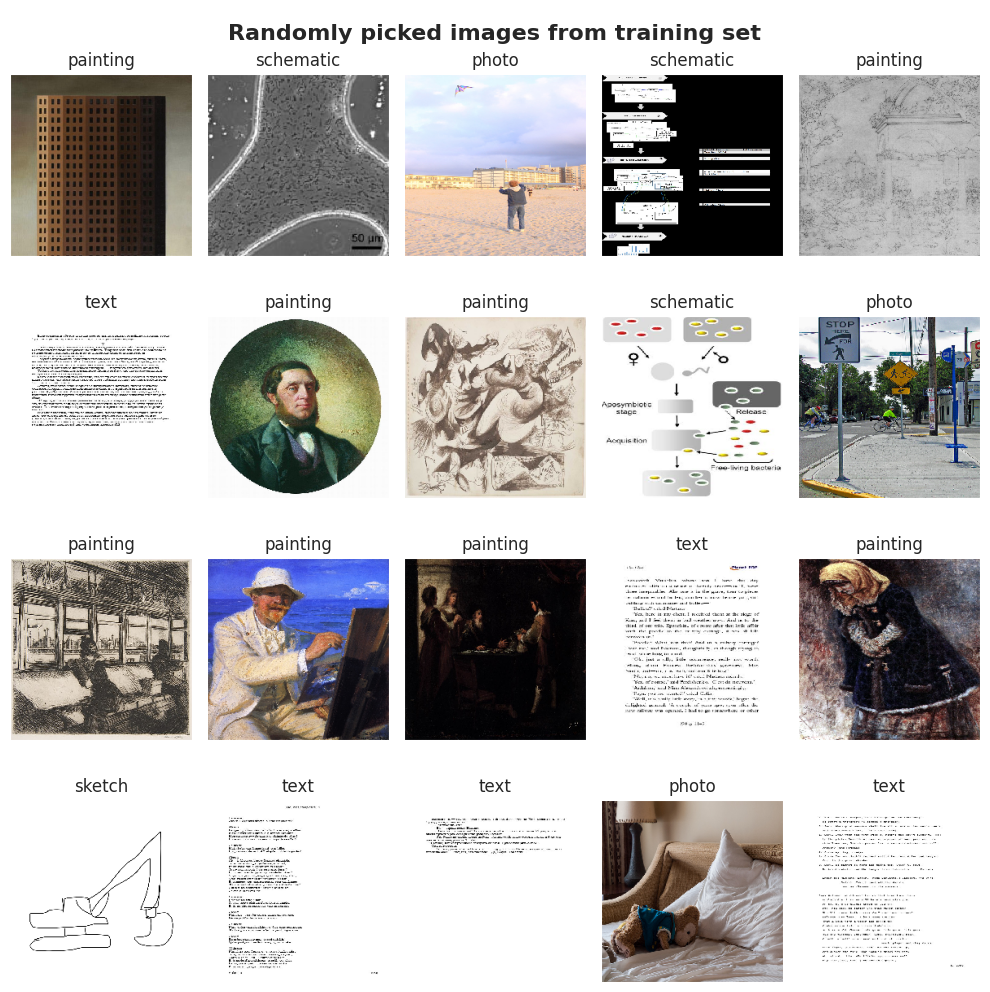

In [9]:
plot_random_images()

## Hyper-parameters <a class="anchor" id="5"></a> 

In order to be able to compare the model troughout the notebook, we chose to train them using the same configuration.

In [10]:
NUM_EPOCH = 15
LOSS = SparseCategoricalCrossentropy()
OPTIMIZER = Adam(1e-3)
METRICS = [SparseCategoricalAccuracy()]

## Deep Neural Network <a class="anchor" id="6"></a> 

### Baseline model

We began with a dummy `dnn_1`, we want to visualize how a poorly designed network behave with our data.

It is only composed of a Flatten and `Dense` ouput layer.

In [11]:
dnn_1 = Sequential([
    Flatten(input_shape=(IMG_H, IMG_W, 3)),
    Dense(units=len(CLASS_NAMES), activation='softmax')
], name='dnn_1')

dnn_1.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(dnn_1)

In [12]:
if is_model_already_trained(dnn_1):
    load_model_training(dnn_1)
else:
    dnn_1.fit(train_data,
              epochs= NUM_EPOCH,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data))
            
    save_model_training(dnn_1)

Epoch 1/15
1017/1017 [==============================] - 537s 524ms/step - loss: 12.7593 - sparse_categorical_accuracy: 0.4475 - val_loss: 12.9289 - val_sparse_categorical_accuracy: 0.3188
Epoch 2/15
1017/1017 [==============================] - 245s 240ms/step - loss: 9.4423 - sparse_categorical_accuracy: 0.5145 - val_loss: 11.1687 - val_sparse_categorical_accuracy: 0.5139
Epoch 3/15
1017/1017 [==============================] - 227s 223ms/step - loss: 9.3114 - sparse_categorical_accuracy: 0.5363 - val_loss: 9.4269 - val_sparse_categorical_accuracy: 0.5284
Epoch 4/15
1017/1017 [==============================] - 233s 229ms/step - loss: 8.2509 - sparse_categorical_accuracy: 0.5648 - val_loss: 6.2906 - val_sparse_categorical_accuracy: 0.5232
Epoch 5/15
1017/1017 [==============================] - 226s 222ms/step - loss: 8.4286 - sparse_categorical_accuracy: 0.5726 - val_loss: 8.3782 - val_sparse_categorical_accuracy: 0.5643
Epoch 6/15
1017/1017 [==============================] - 230s 226ms/

Without any surprise, the `loss` had trouble to decrease and the `accuracy` increase really slowly.

It is even worse for the `val_loss` and `val_accuracy` which are complety chaotic.

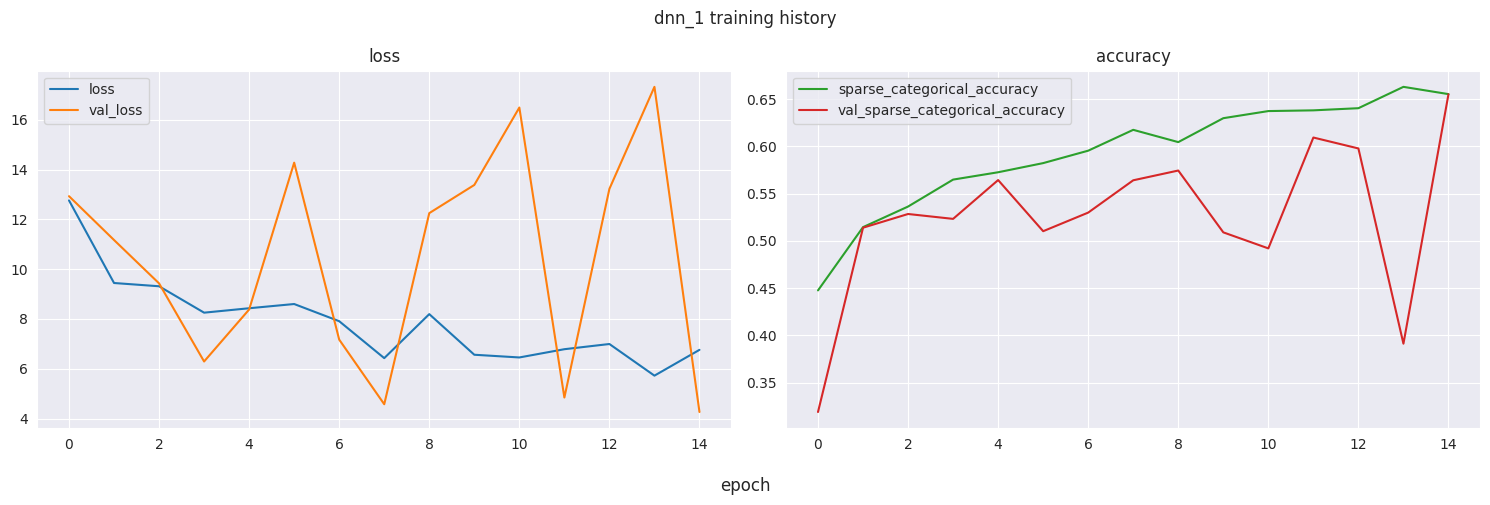

In [13]:
plot_model_history(dnn_1)

`dnn_1` barely reach the 60% of accuracy.

In [14]:
dnn_1.evaluate(test_data)

128/128 [==============================] - 60s 468ms/step - loss: 4.4460 - sparse_categorical_accuracy: 0.6466


[4.445957183837891, 0.6466109752655029]

### Adding hidden layers

To start building a real network, we're adding multiple hidden layers.

`dnn_2` is made of 4 `Dense` hidden layers of respectively 1024, 512, 256, and 128 units, actived with the ReLU function.

In [15]:
dnn_2 = Sequential([
    Flatten(input_shape=(IMG_H, IMG_W, 3)),
    Dense(units=1024, activation='relu'),
    Dense(units=512, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=len(CLASS_NAMES), activation='softmax')
], name='dnn_2')

dnn_2.compile(loss=LOSS,
              optimizer=OPTIMIZER,
              metrics=METRICS)

visualkeras.layered_view(dnn_2)

In [16]:
dnn_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) #rajouter avec chatgpt

if is_model_already_trained(dnn_2):
    load_model_training(dnn_2)
else:
    dnn_2.fit(train_data,
              epochs= NUM_EPOCH,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data))
            
    save_model_training(dnn_2)

Epoch 1/15
1017/1017 [==============================] - 232s 226ms/step - loss: 4.5424 - accuracy: 0.5179 - val_loss: 0.8055 - val_accuracy: 0.6731
Epoch 2/15
1017/1017 [==============================] - 229s 225ms/step - loss: 0.8269 - accuracy: 0.6546 - val_loss: 0.7737 - val_accuracy: 0.6354
Epoch 3/15
1017/1017 [==============================] - 229s 225ms/step - loss: 0.7822 - accuracy: 0.6725 - val_loss: 0.6830 - val_accuracy: 0.7178
Epoch 4/15
1017/1017 [==============================] - 230s 226ms/step - loss: 0.7457 - accuracy: 0.6821 - val_loss: 0.6660 - val_accuracy: 0.7198
Epoch 5/15
1017/1017 [==============================] - 231s 227ms/step - loss: 0.7050 - accuracy: 0.7018 - val_loss: 0.6845 - val_accuracy: 0.6999
Epoch 6/15
1017/1017 [==============================] - 227s 223ms/step - loss: 0.7575 - accuracy: 0.6993 - val_loss: 1.0451 - val_accuracy: 0.5429
Epoch 7/15
1017/1017 [==============================] - 224s 220ms/step - loss: 0.7194 - accuracy: 0.6964 - val_

It's already doing much better.

The `loss` drops down quickly, and the `accuracy` is increasing. <br>
However, the `val_loss` and `val_accuracy` do not change a lot over time.

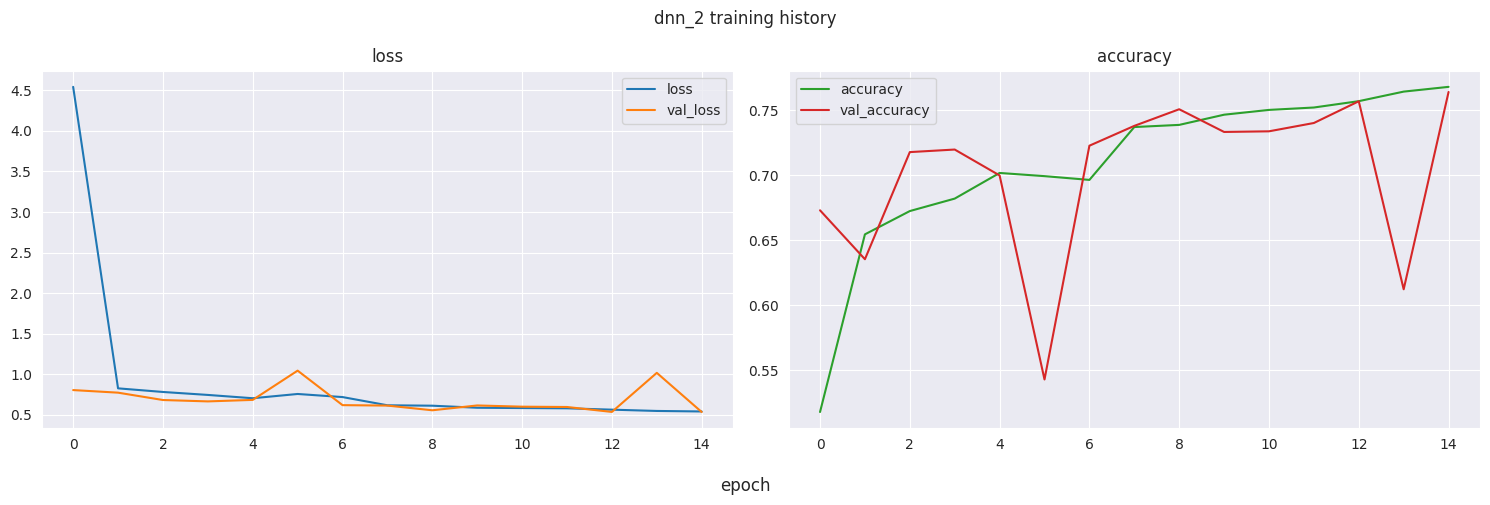

In [17]:
plot_model_history(dnn_2)

Compare to `dnn_1`, `dnn_2` is more accurate but not enough to provide an efficient solution.

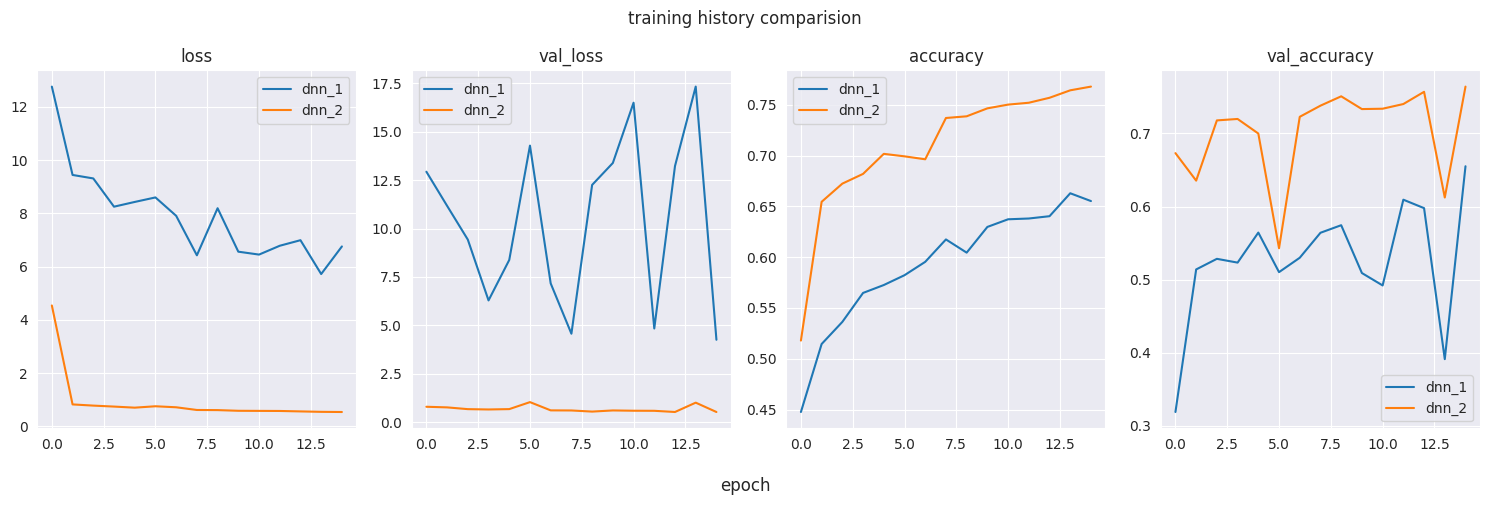

In [18]:
load_model_training(dnn_1) 

plot_models_history([dnn_1, dnn_2])

`dnn_2` only offers an accuracy of 75%.

In [19]:
dnn_2.evaluate(test_data)

128/128 [==============================] - 29s 224ms/step - loss: 0.5364 - accuracy: 0.7748


[0.536384105682373, 0.7748035192489624]

## Convolutional Neural Network <a class="anchor" id="7"></a> 

The reason of the bad performance of `dnn_1` and `dnn_2` for image classification is that Deep Neural Networks are not designed for that kind of task.

Convolutional Neural Networks were invented to provide a more meaningful way to analyse images in order to classify them. <br>
Instead of processing all the pixels of an image at once, it goes through pixels groups using a kernel in order to detect image specificities like contours, edges or color changes.

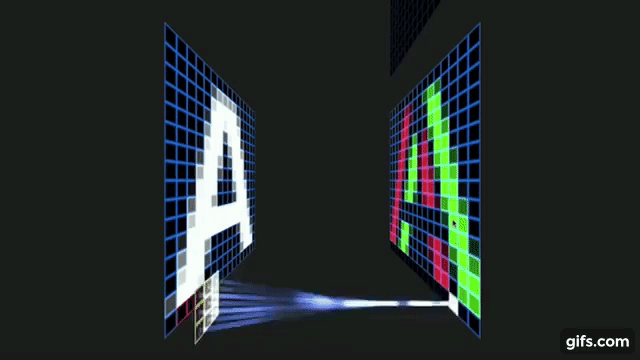

### Baseline model

Let's create a first simple one to see how more efficient it is regarding `dnn_2`.

`cnn_1` is composed of 2 `Conv2D` layers with 23 filter and a kernel size of 2, activated using the ReLU function. <br>
To classify, a simple `Dense` output layer is used.

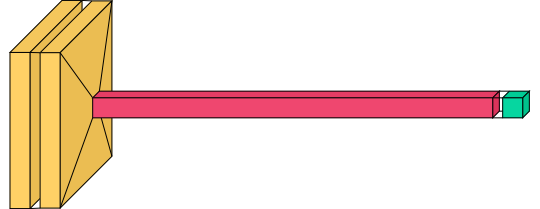

In [20]:
cnn_1 = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)), 
    Conv2D(filters=32, kernel_size=2, activation='relu'),
    Conv2D(filters=32, kernel_size=2, activation='relu'),
    Flatten(),
    Dense(len(CLASS_NAMES), activation='softmax')
], name='cnn_1')

cnn_1.compile(loss=LOSS,
              optimizer='adam',
              metrics=METRICS)

visualkeras.layered_view(cnn_1, scale_xy=0.7)

In [21]:
if is_model_already_trained(cnn_1):
    load_model_training(cnn_1)
else:
    cnn_1.fit(train_data,
              epochs= NUM_EPOCH,
              steps_per_epoch = len(train_data),
              validation_data = val_data,
              validation_steps = len(val_data))
            
    save_model_training(cnn_1)

Epoch 1/15
1017/1017 [==============================] - 252s 243ms/step - loss: 0.8902 - sparse_categorical_accuracy: 0.7603 - val_loss: 0.4492 - val_sparse_categorical_accuracy: 0.8288
Epoch 2/15
1017/1017 [==============================] - 231s 227ms/step - loss: 0.2052 - sparse_categorical_accuracy: 0.9354 - val_loss: 0.5855 - val_sparse_categorical_accuracy: 0.8069
Epoch 3/15
1017/1017 [==============================] - 232s 228ms/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9762 - val_loss: 0.6545 - val_sparse_categorical_accuracy: 0.8389
Epoch 4/15
1017/1017 [==============================] - 227s 223ms/step - loss: 0.0650 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.6884 - val_sparse_categorical_accuracy: 0.8374
Epoch 5/15
1017/1017 [==============================] - 227s 223ms/step - loss: 0.0360 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.8586 - val_sparse_categorical_accuracy: 0.8248
Epoch 6/15
1017/1017 [==============================] - 227s 223ms/ste

We are on the way as `cnn_1`'s `loss` is almost 0 and its `accuracy` tends toward 100%.

However, a bigger problem is now showing up: overfitting.

From this point, our biggest challenge is going to make the `val_loss` decrease while increasing the `val_accuracy`.

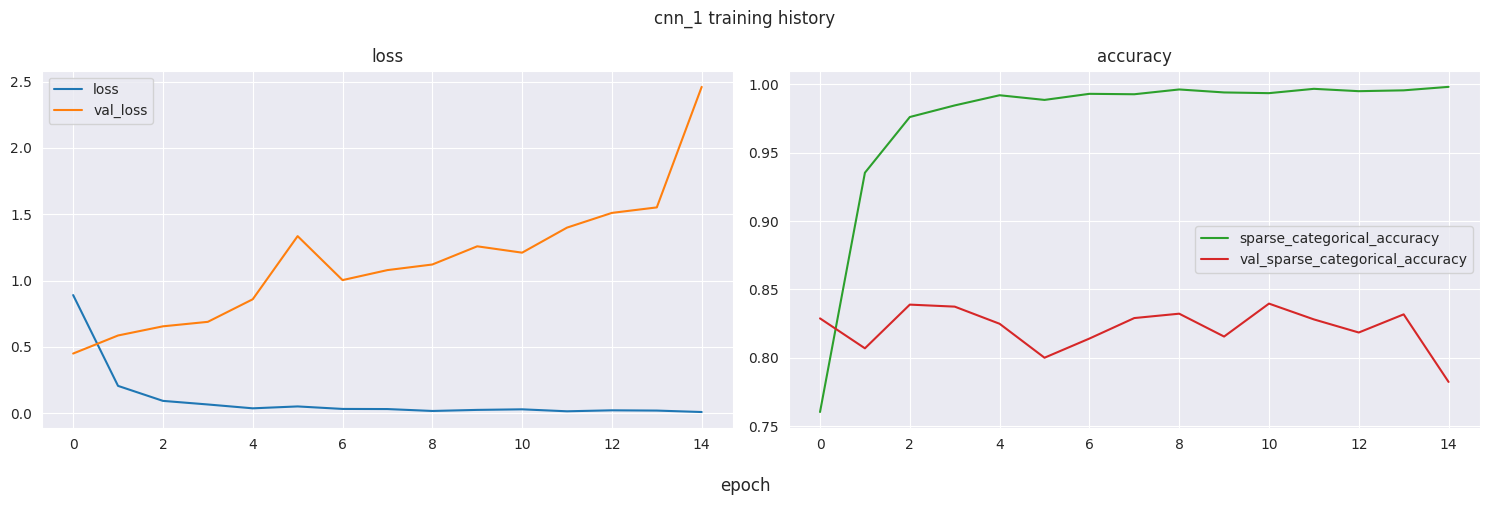

In [22]:
plot_model_history(cnn_1)

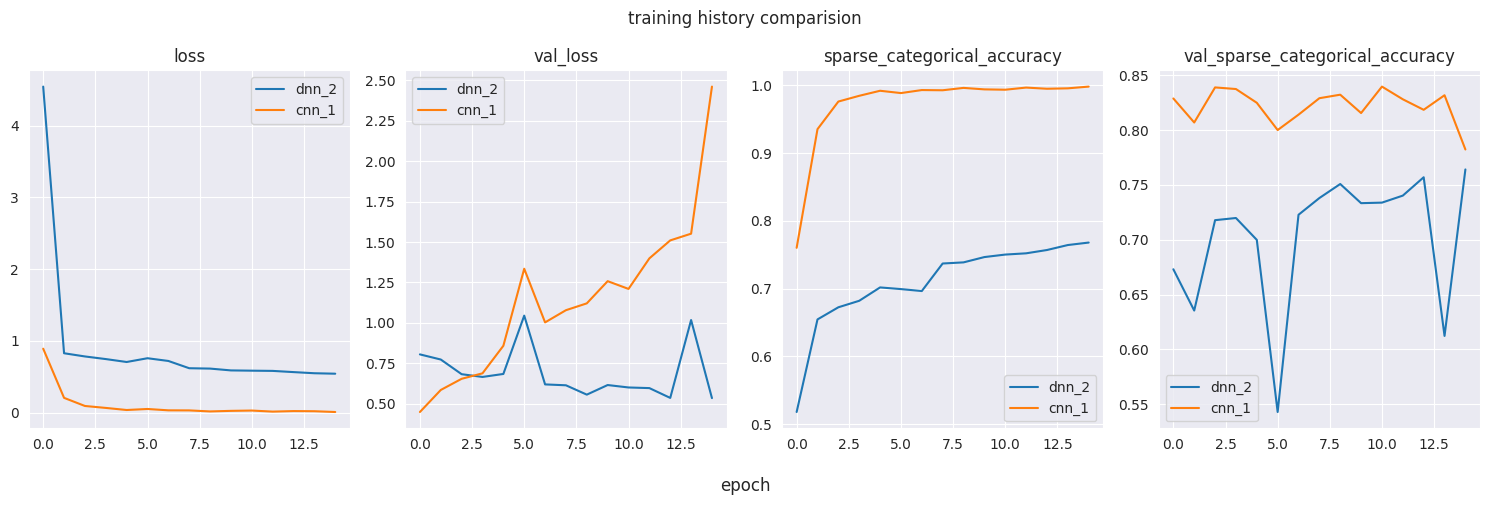

In [23]:
load_model_training(dnn_2)

plot_models_history([dnn_2, cnn_1])

This first iteration gives an accuracy around 80%. 

In [24]:
cnn_1.evaluate(test_data)

128/128 [==============================] - 29s 226ms/step - loss: 2.7278 - sparse_categorical_accuracy: 0.7890


[2.727813482284546, 0.789047122001648]

### Adding max-pooling layers

To improve our model, we can add `MaxPool2D` layers after each convolutional layer.

Max-pooling allows to encode an image into smaller dimension by only keeping the maximum pixel value during the kernel iteration. <br>
It has many advantages such as only keeping relevant image information and reducing the duration of the training.

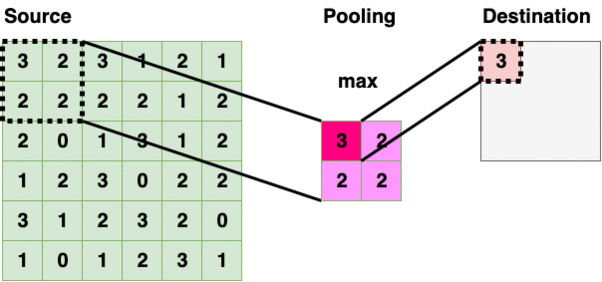

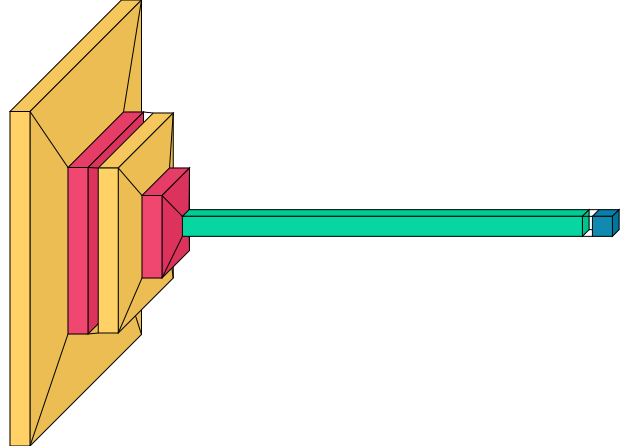

In [25]:
cnn_2 = Sequential([
    Input(shape = (224, 224, 3)),   
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), 
    MaxPool2D(pool_size = 2), # It will reduce the number of features by half
    Conv2D(filters = 32, kernel_size =2, padding = 'valid', activation = 'relu'),
    MaxPool2D(pool_size = 2),
    Flatten(),
    Dense(len(CLASS_NAMES), activation = 'softmax')  
], name='cnn_2')

cnn_2.compile(loss = LOSS,
              optimizer = "adam",
              metrics = METRICS)

visualkeras.layered_view(cnn_2, scale_xy=1.5)

In [26]:
if is_model_already_trained(cnn_2):
    load_model_training(cnn_2)
else:               
    cnn_2.fit(train_data,
            epochs= NUM_EPOCH,
            steps_per_epoch = len(train_data),
            validation_data = val_data,
            validation_steps = len(val_data))
            
    save_model_training(cnn_2)

Epoch 1/15
1017/1017 [==============================] - 229s 224ms/step - loss: 0.5881 - sparse_categorical_accuracy: 0.7774 - val_loss: 0.4628 - val_sparse_categorical_accuracy: 0.8308
Epoch 2/15
1017/1017 [==============================] - 229s 225ms/step - loss: 0.3380 - sparse_categorical_accuracy: 0.8671 - val_loss: 0.3505 - val_sparse_categorical_accuracy: 0.8536
Epoch 3/15
1017/1017 [==============================] - 226s 222ms/step - loss: 0.2539 - sparse_categorical_accuracy: 0.9055 - val_loss: 0.3460 - val_sparse_categorical_accuracy: 0.8760
Epoch 4/15
1017/1017 [==============================] - 234s 230ms/step - loss: 0.1775 - sparse_categorical_accuracy: 0.9348 - val_loss: 0.4232 - val_sparse_categorical_accuracy: 0.8615
Epoch 5/15
1017/1017 [==============================] - 236s 232ms/step - loss: 0.1362 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.4187 - val_sparse_categorical_accuracy: 0.8740
Epoch 6/15
1017/1017 [==============================] - 227s 223ms/ste

Despite the max-pooling, `cnn_2` is still overfitting but this time much slower.

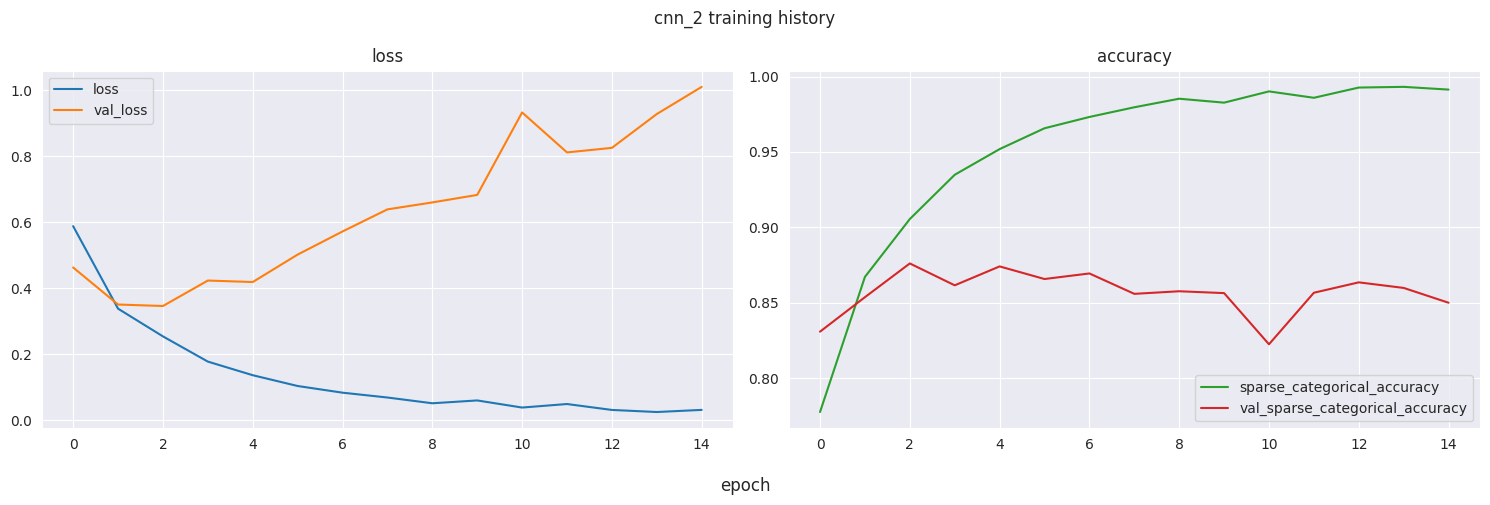

In [27]:
plot_model_history(cnn_2)

It's quite a good improvement compare to `cnn_1`, especially regarding the `val_accuracy`.

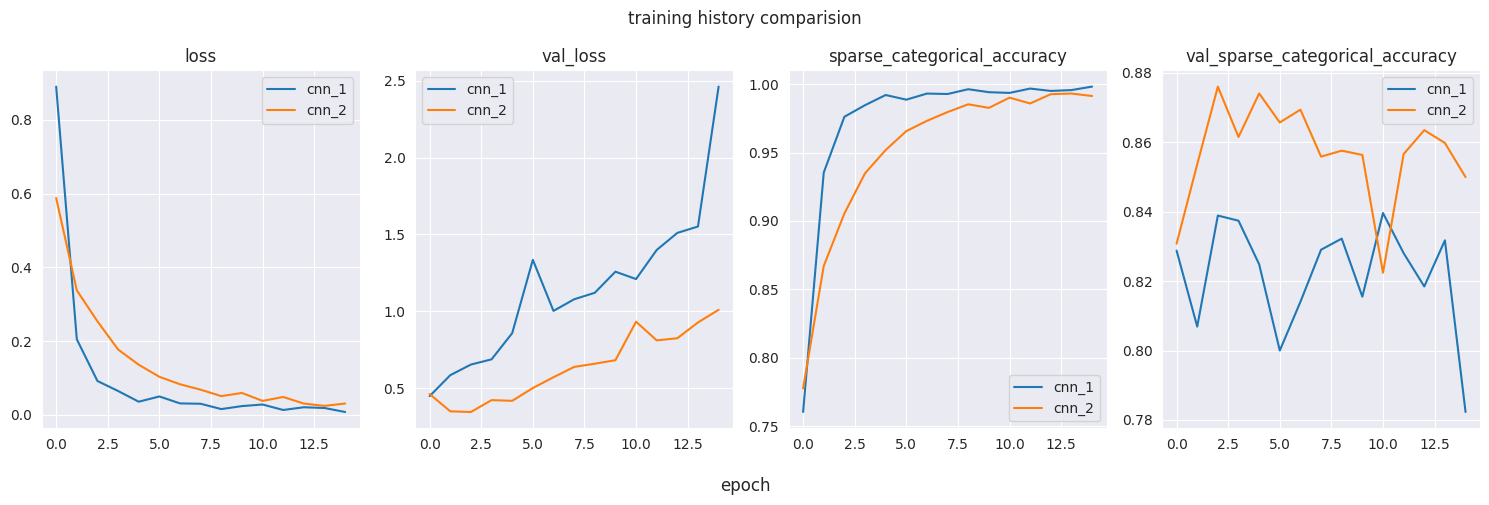

In [28]:
load_model_training(cnn_1)

plot_models_history([cnn_1, cnn_2])

`cnn_2` does sligthly better than it predecessor, reaching 84% of accuracy.

In [29]:
test_data.reset()

In [30]:
cnn_2.evaluate(test_data)

128/128 [==============================] - 28s 221ms/step - loss: 0.9963 - sparse_categorical_accuracy: 0.8632


[0.9962945580482483, 0.8632121682167053]

### Encoder

To improve our solution even more, we can create an encoder.

To do so, we can add more `Conv2D` layers with an increasing number of filters and a bigger kernel size.

To also improve the classification at the end of the convolution, we add a `Dense` layer of 512 units, precede by a `Droupout` of 50%.

Dropout is one of many techniques of weight regularization that helps reduce overfitting by randomly ignoring a certain percentage of neuron connections between two layers in each epoch.

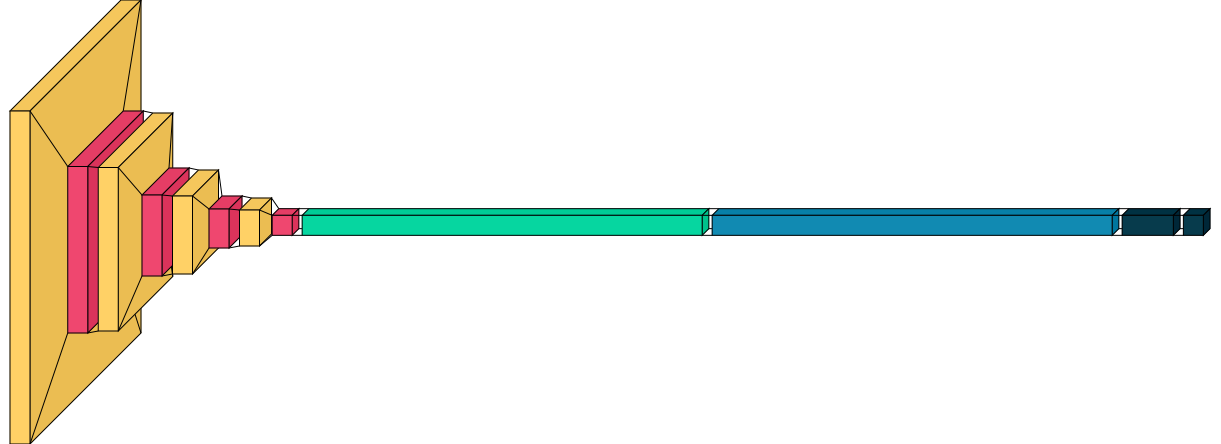

In [31]:
cnn_3 = Sequential([
    Input(shape=(IMG_H, IMG_W, 3)),
    Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(units=512, activation='relu'),
    Dense(units=len(CLASS_NAMES), activation='softmax')
], name='cnn_3')

cnn_3.compile(loss = LOSS,
              optimizer = OPTIMIZER,
              metrics = METRICS)

visualkeras.layered_view(cnn_3, scale_xy=1.5)

In [32]:
cnn_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

if is_model_already_trained(cnn_3):
    load_model_training(cnn_3)
else:               
    cnn_3.fit(train_data,
            epochs= NUM_EPOCH,
            steps_per_epoch = len(train_data),
            validation_data = val_data,
            validation_steps = len(val_data))
            
    save_model_training(cnn_3)

Epoch 1/15
1017/1017 [==============================] - 231s 224ms/step - loss: 0.5669 - accuracy: 0.7614 - val_loss: 0.3963 - val_accuracy: 0.8369
Epoch 2/15
1017/1017 [==============================] - 227s 223ms/step - loss: 0.3887 - accuracy: 0.8415 - val_loss: 0.3634 - val_accuracy: 0.8627
Epoch 3/15
1017/1017 [==============================] - 254s 249ms/step - loss: 0.3204 - accuracy: 0.8705 - val_loss: 0.3320 - val_accuracy: 0.8918
Epoch 4/15
1017/1017 [==============================] - 257s 253ms/step - loss: 0.2740 - accuracy: 0.8908 - val_loss: 0.4688 - val_accuracy: 0.8839
Epoch 5/15
1017/1017 [==============================] - 261s 256ms/step - loss: 0.2319 - accuracy: 0.9090 - val_loss: 0.3112 - val_accuracy: 0.8841
Epoch 6/15
1017/1017 [==============================] - 245s 240ms/step - loss: 0.2027 - accuracy: 0.9235 - val_loss: 2.1341 - val_accuracy: 0.9031
Epoch 7/15
1017/1017 [==============================] - 238s 234ms/step - loss: 0.1805 - accuracy: 0.9320 - val_

With this type of architecture, `cnn_3` is finally starting to behave correctly.

Even if not by a lot, `val_loss` decreased and `val_accuracy` increased during the training.

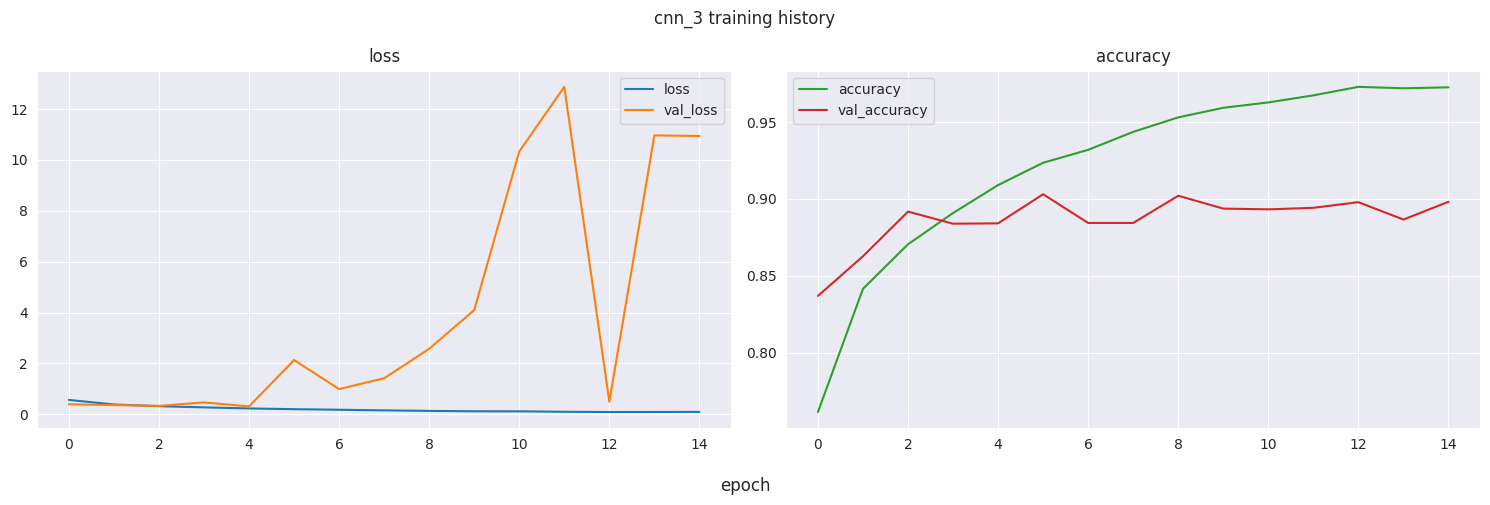

In [33]:
plot_model_history(cnn_3)

In comparision with the previous model, `cnn_3` is much more promising.

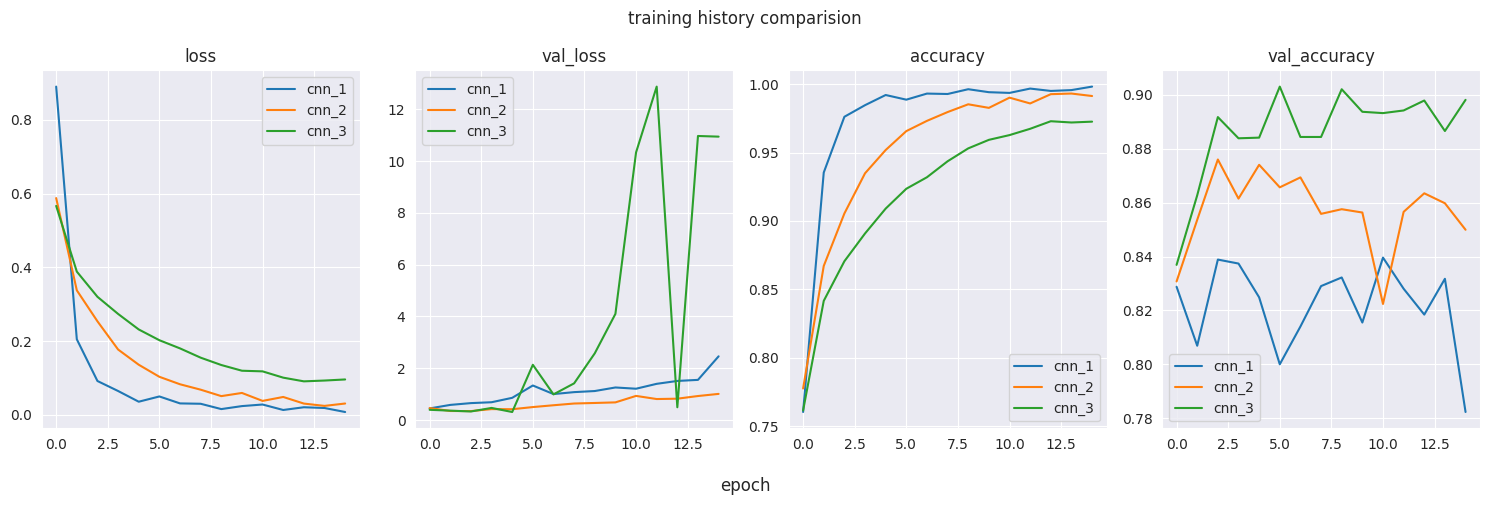

In [34]:
load_model_training(cnn_1)
load_model_training(cnn_2)

plot_models_history([cnn_1, cnn_2, cnn_3])

After its training, `cnn_3` is just over 86% of accuracy.

In [35]:
cnn_3.evaluate(test_data)

128/128 [==============================] - 30s 232ms/step - loss: 70.3364 - accuracy: 0.9005


[70.33635711669922, 0.900540292263031]

## Improving models <a class="anchor" id="8"></a> 

Moving forward, the enhancement of our models primarily depends on the iterative process of trial and error. It is indeed the case that as of today, there is no established method for determining the optimal model architecture for a specific problem. This area remains an active field of research.

Nevertheless, there are recognized techniques, known as regularization, which can be applied to mitigate overfitting and enhance validation accuracy during the training process

### Dropout

Already employed in 'cnn_3', dropout enables a specific percentage of neuron connections between two layers to be randomly ignored in each epoch.

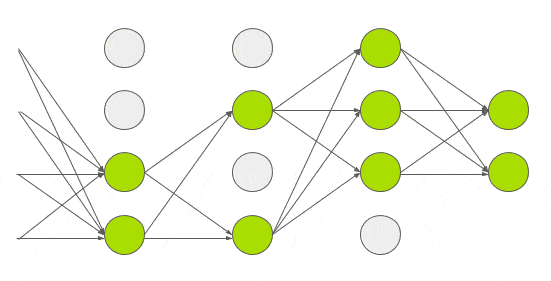

### L1 and L2 regularization

Allows to constrain the weights of a model to be smaller or to shrink some of them to 0.

### Early-stopping

Stops the training of a model when a metric such as the loss or the accuracy stop improving.

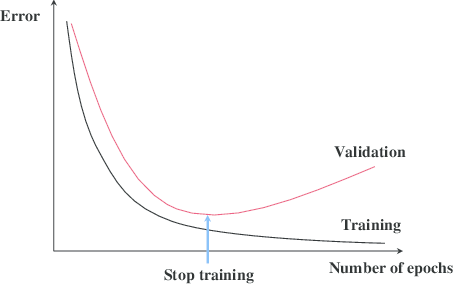

### Data augmentation

When dealing with image classes, it's possible to generate fresh data by applying various transformations to images from a dataset. These transformations can include cropping, rotations, symmetries, shifting, or color adjustments.

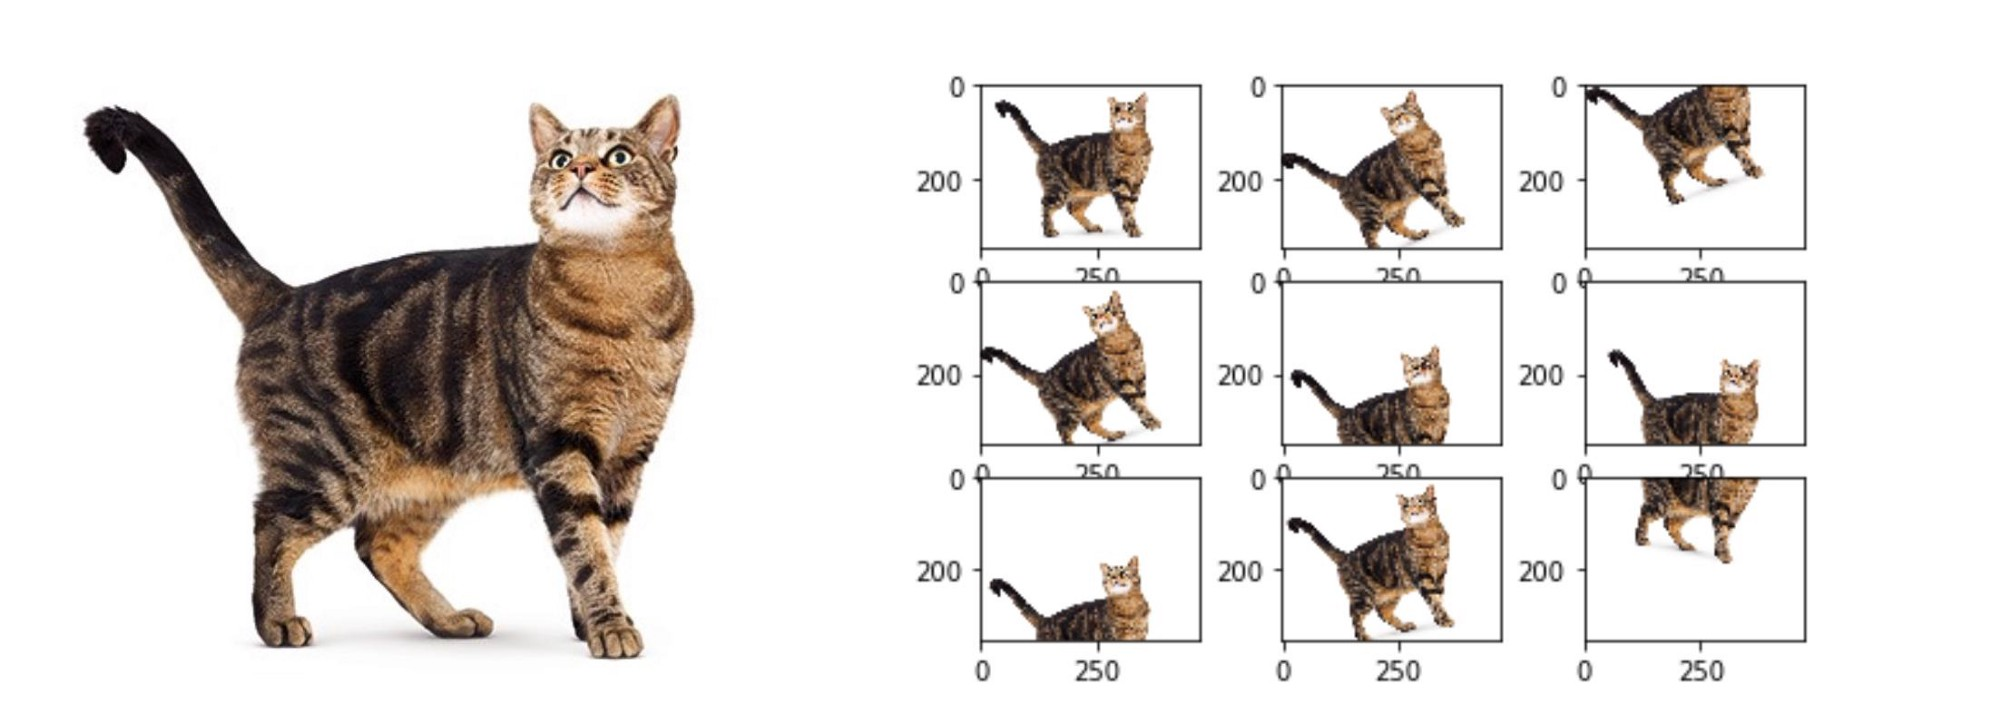

## Improving training <a class="anchor" id="9"></a> 

Random Search is a method employed to optimize hyperparameters and identify the most suitable configuration for our model. Essentially, it evaluates a set of parameter combinations chosen randomly. Nevertheless, it's worth noting that this technique demands a significant amount of computational resources. 

The following code can be used in order to implement this technique:

```python
from  keras_tuner import RandomSearch
random_s= RandomSearch(cnn_3,
                       objectives= 'val_accuracy',
                       max_trials=15)
random_s.seach(train_data,
               epochs=5,
               validation_data= val_data,
               callbacks=[tf.keras.callbacks.EarlyStopping(patiente=1)])
```

## Transfer Learning <a class="anchor" id="10"></a>  

The concept underlying Transfer Learning involves taking a pre-existing model that has undergone training for a task similar to ours and subsequently fine-tuning it to align with our specific requirements.

This approach is significantly more efficient when compared to the trial-and-error method, primarily because many models have already been developed, trained, and extensively documented, often surpassing what we could envision independently.

### VGG16

VGG16 is a Convolutional Neural Network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for the Large-Scale Image Recognition”.

The model achieves 92.7% test accuracy in ImageNet, which is the dataset of over 14 million images belonging to 1000 classes.

Since our goal is similar, it would be interesting to try using Transfer Learning with this model.

In [36]:
base_model_vgg = tf.keras.applications.VGG16(input_shape = (IMG_H, IMG_W, 3),
                                             include_top = False,
                                             weights = 'imagenet')
                                             
for layer in base_model_vgg.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


Since we only want to keep the weigths of the VGG16 model, we desactivated the training of the convolutional layers.

Then to classify our images, we add the same `Dense` and `Dropout` layer configuration as our `cnn_3`.

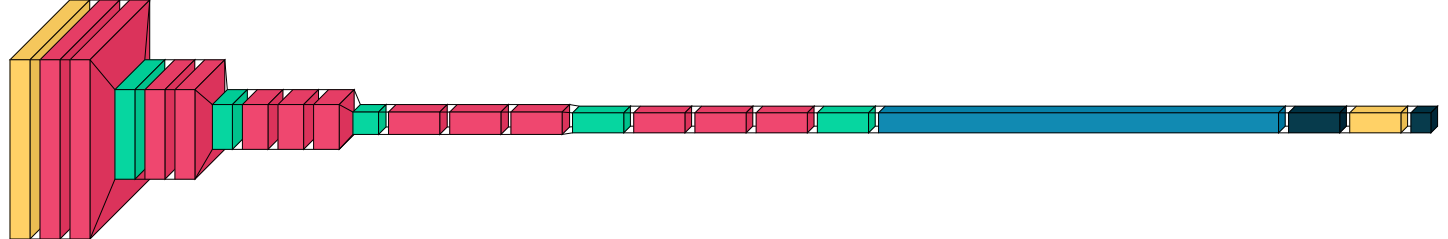

In [37]:
x = tf.keras.layers.Flatten()(base_model_vgg.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

vgg_16 = tf.keras.models.Model(base_model_vgg.input, x) #merge the original VGG-16 layers, with our custom layers.
vgg_16._name = 'vgg_16'

vgg_16.compile(loss = LOSS,
               optimizer = OPTIMIZER,
               metrics = METRICS)
               
visualkeras.layered_view(vgg_16, scale_xy=0.8)

In [38]:
vgg_16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
if is_model_already_trained(vgg_16):
    load_model_training(vgg_16)
else:               
    vgg_16.fit(train_data,
            epochs= 5,
            steps_per_epoch = len(train_data),
            validation_data = val_data,
            validation_steps = len(val_data))
            
    save_model_training(vgg_16)

Epoch 1/5
1017/1017 [==============================] - 239s 232ms/step - loss: 0.4087 - accuracy: 0.8568 - val_loss: 136.2309 - val_accuracy: 0.9122
Epoch 2/5
1017/1017 [==============================] - 228s 224ms/step - loss: 0.2564 - accuracy: 0.9020 - val_loss: 38.0431 - val_accuracy: 0.9294
Epoch 3/5
1017/1017 [==============================] - 231s 227ms/step - loss: 0.2163 - accuracy: 0.9185 - val_loss: 38.7192 - val_accuracy: 0.9338
Epoch 4/5
1017/1017 [==============================] - 231s 227ms/step - loss: 0.1920 - accuracy: 0.9273 - val_loss: 83.3985 - val_accuracy: 0.9351
Epoch 5/5
1017/1017 [==============================] - 231s 227ms/step - loss: 0.1802 - accuracy: 0.9305 - val_loss: 646.6672 - val_accuracy: 0.9383


Even if we reduce the number of epoch to 5 due to a lack of computational power, the re-trained VGG16 complety outperform our `cnn_3`.

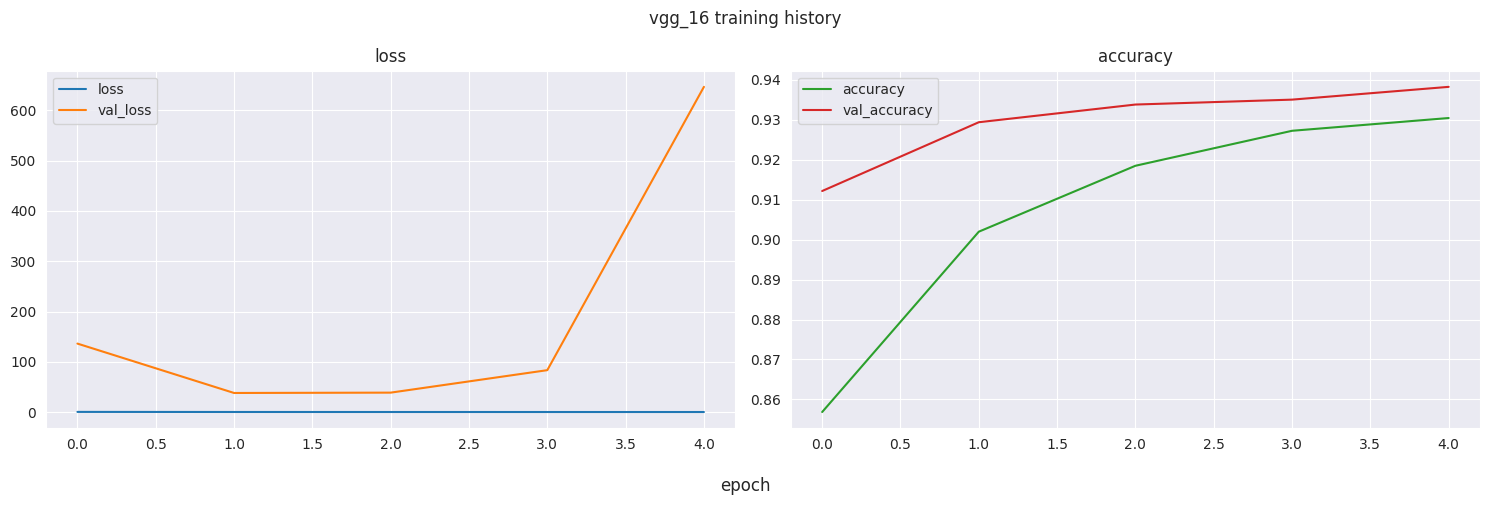

In [39]:
plot_model_history(vgg_16)

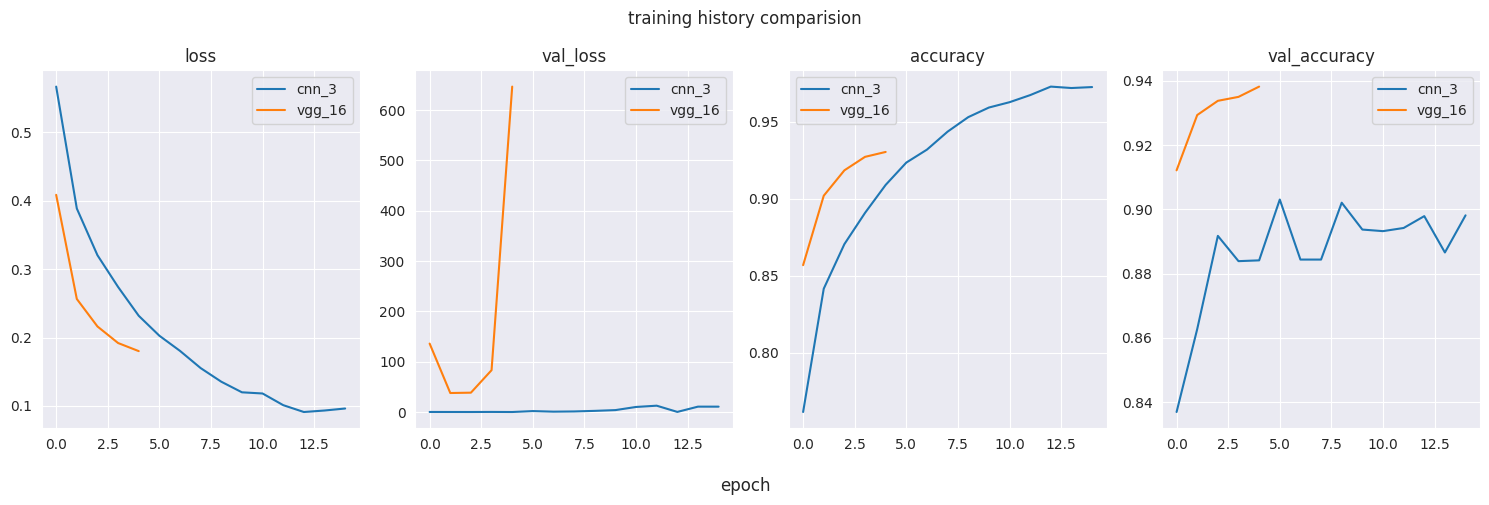

In [40]:
load_model_training(cnn_3)

plot_models_history([cnn_3, vgg_16])

`vgg_16` gives us an astonishing 94% of accuracy.

In [41]:
vgg_16.evaluate(test_data)

128/128 [==============================] - 30s 230ms/step - loss: 0.2192 - accuracy: 0.9283


[0.21922138333320618, 0.9282907843589783]

### EfficientNetB7

EffecientNetB7 is a Convolutional Neural Network develop by Google AI, which reachs state-of-the-art accuracy on biggest image classification datasets.

In [42]:
feature_extractor_layer = tf_hub.KerasLayer('https://tfhub.dev/google/efficientnet/b7/feature-vector/1',
                                            trainable=False,
                                            input_shape=(224, 224, 3))

ef_net_b7 = Sequential([
    feature_extractor_layer,
    Dense(len(CLASS_NAMES), activation='softmax')
], name='ef_net_b7')

ef_net_b7.compile(loss = LOSS,
                  optimizer = OPTIMIZER,
                  metrics = METRICS)

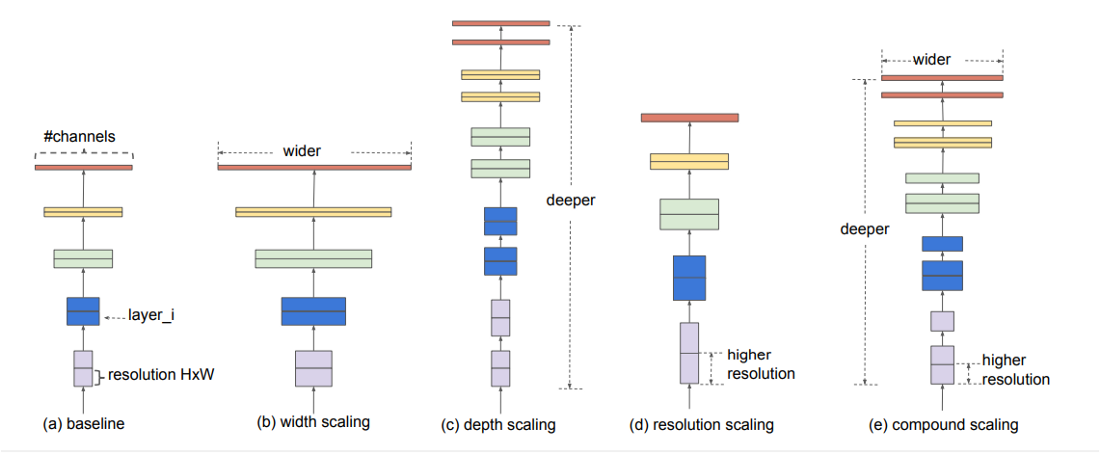

In [43]:
ef_net_b7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
if is_model_already_trained(ef_net_b7):
    load_model_training(ef_net_b7)
else:               
    ef_net_b7.fit(train_data,
                  epochs= 5,
                  steps_per_epoch = len(train_data),
                  validation_data = val_data,
                  validation_steps = len(val_data))
            
    save_model_training(ef_net_b7)

Epoch 1/5
1017/1017 [==============================] - 284s 269ms/step - loss: 0.1750 - accuracy: 0.9503 - val_loss: 0.1183 - val_accuracy: 0.9621
Epoch 2/5
1017/1017 [==============================] - 265s 261ms/step - loss: 0.0944 - accuracy: 0.9699 - val_loss: 0.1049 - val_accuracy: 0.9665
Epoch 3/5
1017/1017 [==============================] - 268s 263ms/step - loss: 0.0785 - accuracy: 0.9755 - val_loss: 0.1003 - val_accuracy: 0.9680
Epoch 4/5
1017/1017 [==============================] - 264s 259ms/step - loss: 0.0690 - accuracy: 0.9786 - val_loss: 0.0976 - val_accuracy: 0.9688
Epoch 5/5
1017/1017 [==============================] - 269s 264ms/step - loss: 0.0619 - accuracy: 0.9810 - val_loss: 0.0988 - val_accuracy: 0.9688


Also trained on 5 epoch, the EfficientNetB7 perform better then the VGG16.

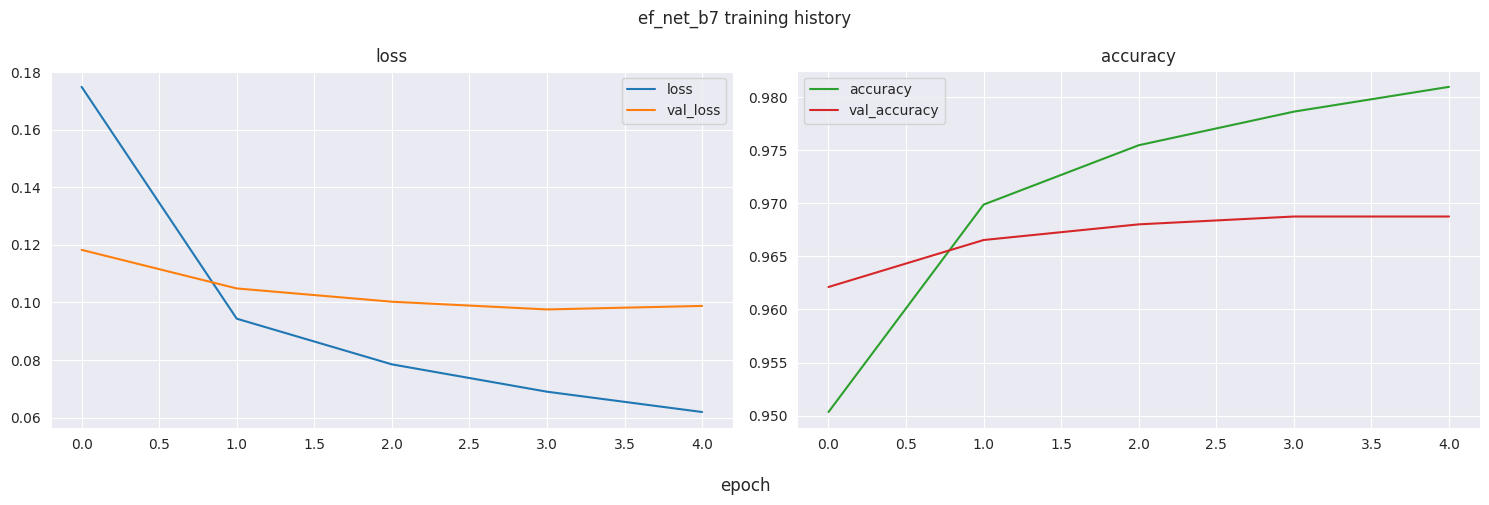

In [44]:
plot_model_history(ef_net_b7)

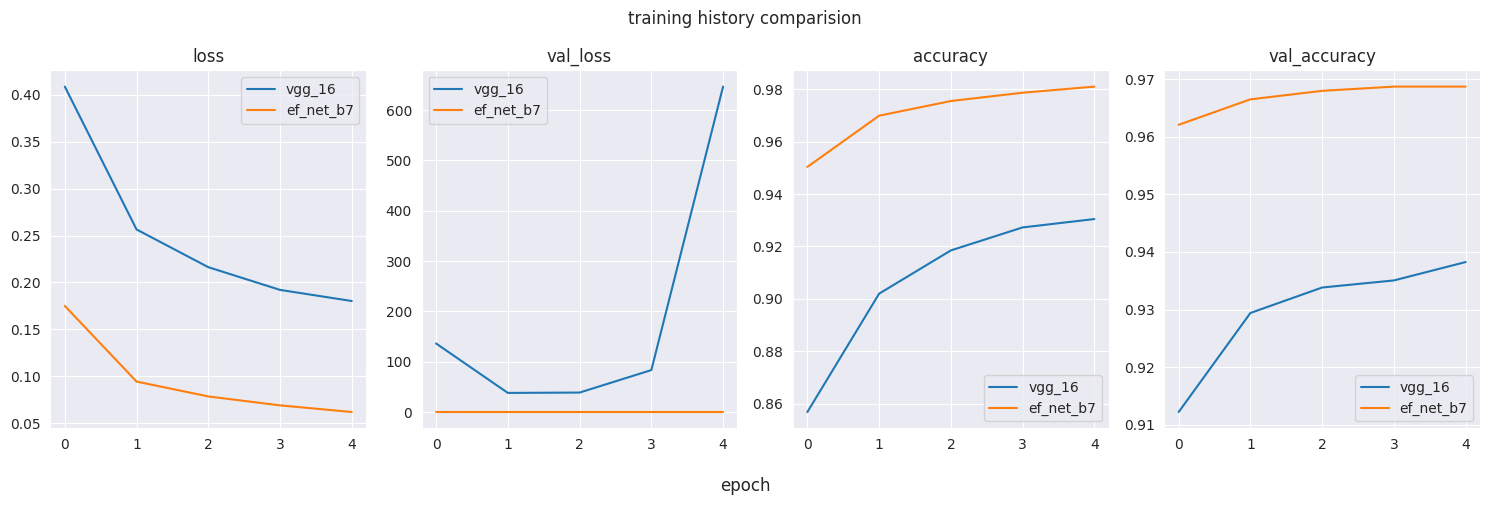

In [45]:
load_model_training(vgg_16)

plot_models_history([vgg_16, ef_net_b7])

`ef_net_b7` ends our image classification solution research with an 95.6% accuracy.

In [46]:
ef_net_b7.evaluate(test_data)

128/128 [==============================] - 32s 249ms/step - loss: 0.0918 - accuracy: 0.9683


[0.09181416034698486, 0.9683202505111694]

## Results <a class="anchor" id="11"></a>  

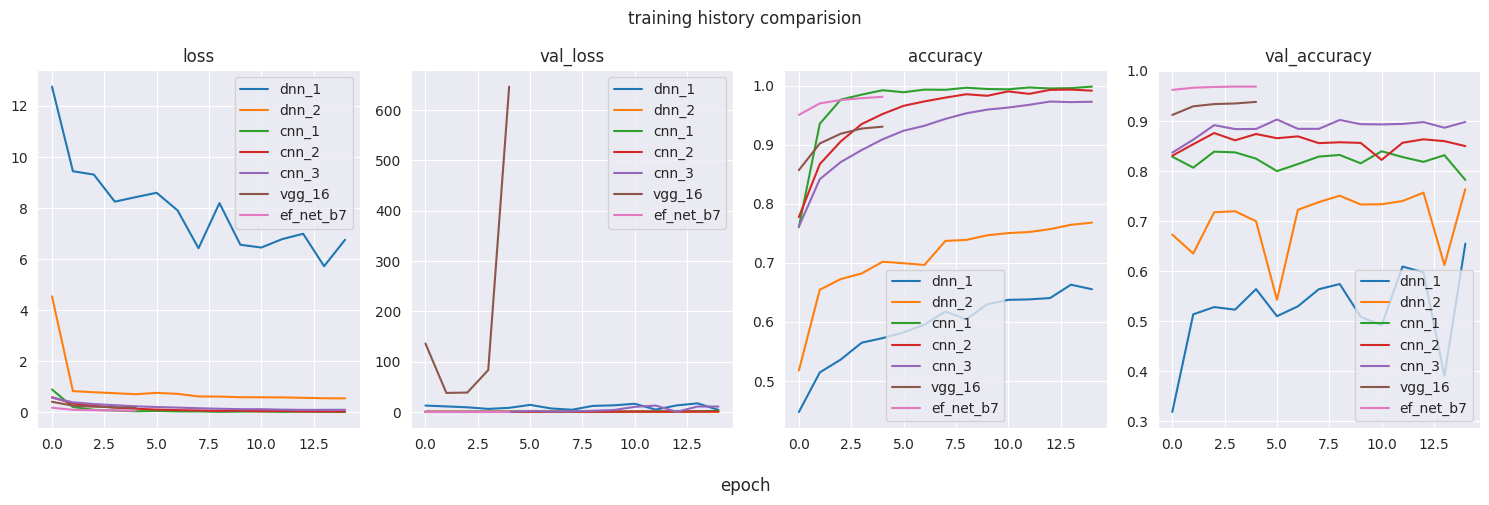

In [47]:
load_model_training(dnn_1)
load_model_training(dnn_2)
load_model_training(cnn_1)
load_model_training(cnn_2)
load_model_training(cnn_3)
load_model_training(vgg_16)
load_model_training(ef_net_b7)

plot_models_history([dnn_1, dnn_2, cnn_1, cnn_2, cnn_3, vgg_16, ef_net_b7])